## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
#!pip install -q hyperopt

In [3]:
%matplotlib inline 

In [4]:
# для математических вычислений
import numpy as np

# для работы с таблицами
import pandas as pd

# для EDA анализа
import ydata_profiling

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# для разбивки данных на выборки
from sklearn.model_selection import train_test_split

# для масштабирования признаков
from sklearn.preprocessing import RobustScaler

# константная модель
from sklearn.dummy import DummyRegressor

# для расчёта качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# модели машинного обучения
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# для подбора гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# для расчёта времени выполнения кода
import time

## 2 Исследовательский анализ данных
Напишем функцию, которая будет считывать данные из csv-файла в датафрейм и выводить его профилирование.

In [89]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    ydata_profiling.ProfileReport(df, progress_bar=False).to_file(name + '.html')
    return df

### 2.1 Электроды
Проведём EDA анализ.

In [90]:
arc_df = read_eda('data_arc_new')

[Посмотреть анализ.](https://www.dropbox.com/s/m0us8i9uzujx0ox/data_arc_new.html?dl=0)

- **Обнаружены некорректные названия столбцов.**
- **Присутствует отрицательная реактивная мощность.**

### 2.2 Подача сыпучих материалов
Проведём EDA анализ.

In [91]:
bulk_df = read_eda('data_bulk_new')

[Посмотреть анализ.](https://www.dropbox.com/s/pm21dawquqboq50/data_bulk_new.html?dl=0)

In [92]:
bulk_time_df = read_eda('data_bulk_time_new')

[Посмотреть анализ.](https://www.dropbox.com/s/g6ridsttu7we275/data_bulk_time_new.html?dl=0)

- **Обнаружены некорректные названия столбцов.**
- **Присутсвуют пропуски.**

### 2.3 Продувка сплава газом
Проведём EDA анализ.

In [93]:
gas_df = read_eda('data_gas_new')

[Посмотреть анализ.](https://www.dropbox.com/s/vns23uftwq6ft2z/data_gas_new.html?dl=0)

**Обнаружено некорректное название столбца.**

### 2.4 Результаты измерения температуры
Проведём EDA анализ.

In [94]:
temp_df = read_eda('data_temp_new')

[Посмотреть анализ.](https://www.dropbox.com/s/ret8rr5e8u5fo38/data_temp_new.html?dl=0)

- **Обнаружены некорректные названия столбцов.**
- **Присутсвуют пропуски.**

Темература плавления стали - 1450 градусов. Проверим, есть ли выбросы с температурой ниже.

In [11]:
def boxplot(df, col, ylabel):
    plt.figure(figsize=(7, 5))
    df.boxplot(col)
    plt.ylabel(ylabel, fontsize=12)
    plt.title('Диаграмма размаха по столбцу ' + col + '\n', fontsize=15)
    plt.show()

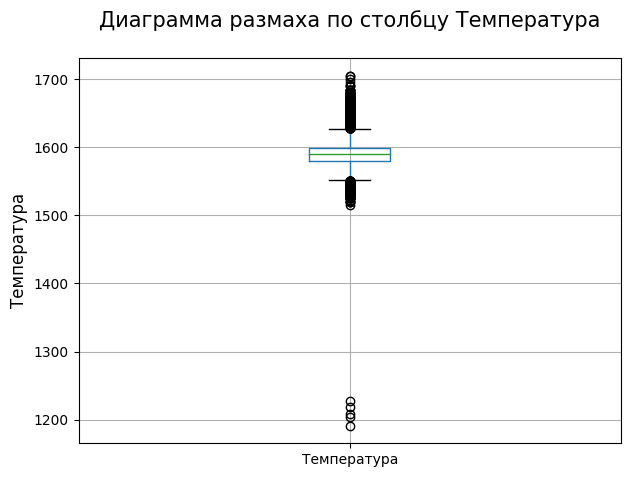

In [12]:
boxplot(temp_df, 'Температура', 'Температура')

**Выбросы есть, их также нужно будет обработать.**

Проверим наличие партий с одним замером.

In [13]:
print('Количество партий с одним замером:', (temp_df['key'].value_counts() == 1).sum())

Количество партий с одним замером: 2


**Такие партии тоже подлежат обработке.**

### 2.5 Проволочные материалы
Проведём EDA анализ.

In [95]:
wire_df = read_eda('data_wire_new')

[Посмотреть анализ.](https://www.dropbox.com/s/2rhx5xr2y9hfk68/data_wire_new.html?dl=0)

In [96]:
wire_time_df = read_eda('data_wire_time_new')

[Посмотреть анализ.](https://www.dropbox.com/s/fqwj3wnx1bwzhwm/data_wire_time_new.html?dl=0)

- **Обнаружены некорректные названия столбцов.**
- **Присутсвуют пропуски.**

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Нужно обработать в данных</b>
       <br><br>
       <i>об электродах:</i>
        <li>названия столбцов;</li>
        <li>отрицательную реактивную мощность;</li>
       <li>партии с одним замером.</li>
        <br>
       <i>о подаче сыпучих материалов и о проволочных материалах:</i>
        <li>названия столбцов;</li>
        <li>пропуски.</li>
        <br>
       <i>о продувке сплава газом название столбца.</i>
       <br><br>
       <i>c результатами измерения температуры:</i>
        <li>названия столбцов;</li>
        <li>пропуски;</li>
       <li>выбросы температуры ниже 1450.</li>
   </p>  
</div>

## 3 Подготовка данных
### 3.1 Электроды
Создадим копию старого датафрейма.

In [16]:
arc_prev_df = arc_df.copy()

Изменим язык и регистр названий столбцов.

In [17]:
arc_df.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

In [18]:
arc_df = arc_df.rename(columns={
    'Начало нагрева дугой': 'start_arc_heating', 
    'Конец нагрева дугой': 'end_arc_heating',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

Уберём партии с отрицательной реактивной мощностью.

In [19]:
arc_df = arc_df[~arc_df['key'].isin(arc_df.query('reactive_power <= 0')['key'].unique())]

Проверим изменения.

In [20]:
arc_df.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [21]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14872 non-null  int64  
 1   start_arc_heating  14872 non-null  object 
 2   end_arc_heating    14872 non-null  object 
 3   active_power       14872 non-null  float64
 4   reactive_power     14872 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.1+ KB


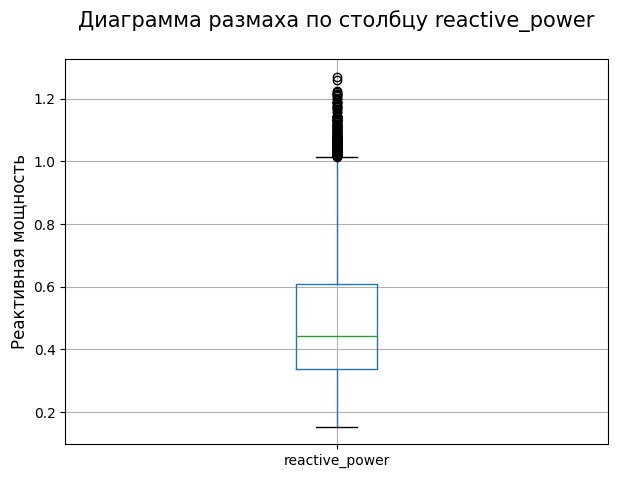

In [22]:
boxplot(arc_df, 'reactive_power', 'Реактивная мощность')

Посмотрим на общий ущерб.

In [23]:
def missing_values(df, prev_df):
    print('Процент удалённых значений:', (prev_df.shape[0] - df.shape[0]) * 100 / prev_df.shape[0])

In [24]:
missing_values(arc_df, arc_prev_df)

Процент удалённых значений: 0.026888948642108095


### 3.2 Подача сыпучих материалов
Создадим копии старых датафреймов.

In [25]:
bulk_prev_df = bulk_df.copy()
bulk_time_prev_df = bulk_time_df.copy()

Изменим регистр названий столбцов.

In [26]:
def change_case(df):
    new_cols = []
    for col in df.columns:
        new_cols.append(col.replace(" ", "_").lower())
    return new_cols

In [27]:
bulk_df.columns = change_case(bulk_df)
bulk_time_df.columns = bulk_df.columns

Так как пропусков много, заменим их нулями.

In [28]:
bulk_df = bulk_df.fillna(0)
bulk_time_df = bulk_time_df.fillna(0)

Проверим изменения.

In [29]:
bulk_df.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [30]:
bulk_time_df.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


In [31]:
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [32]:
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


### 3.3 Продувка сплава газом
Создадим копию старого датафрейма.

In [33]:
gas_prev_df = gas_df.copy()

Изменим язык и регистр названий столбцов.

In [34]:
gas_df.columns

Index(['key', 'Газ 1'], dtype='object')

In [35]:
gas_df = gas_df.rename(columns={'Газ 1': 'gas_1'})

Проверим изменения.

In [36]:
gas_df.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [37]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


### 3.4 Результаты измерения температуры
Создадим копию старого датафрейма.

In [38]:
temp_prev_df = temp_df.copy()

Изменим язык и регистр названий столбцов.

In [39]:
temp_df.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [40]:
temp_df = temp_df.rename(columns={
    'Время замера': 'measurement_time', 
    'Температура': 'temperature'
})

Уберём партии с пропусками.

In [41]:
isna_rows = temp_df.isna().any(axis=1)
keys_with_nan = temp_df[isna_rows]['key'].unique()
temp_df = temp_df[~temp_df['key'].isin(keys_with_nan)]

Удалим партии с выбросами температуры ниже 1450.

In [42]:
temp_df = temp_df[~temp_df['key'].isin(temp_df.query('temperature <= 1450')['key'].unique())]

Уберём партии с одним замером

In [43]:
temp_df = temp_df[temp_df.groupby('key')['key'].transform('size') != 1]

Проверим изменения.

In [44]:
temp_df.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [45]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               13903 non-null  int64  
 1   measurement_time  13903 non-null  object 
 2   temperature       13903 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


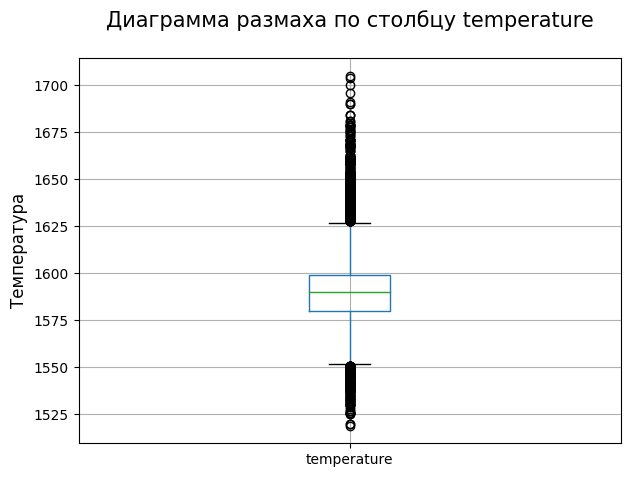

In [46]:
boxplot(temp_df, 'temperature', 'Температура')

Посмотрим на общий ущерб.

In [47]:
missing_values(temp_df, temp_prev_df)

Процент удалённых значений: 23.153880168030067


### 3.5 Проволочные материалы
Создадим копии старых датафреймов.

In [48]:
wire_prev_df = wire_df.copy()
wire_time_prev_df = wire_time_df.copy()

Изменим регистр названий столбцов.

In [49]:
wire_df.columns = change_case(wire_df)
wire_time_df.columns = wire_df.columns

Так как пропусков много, заменим их нулями.

In [50]:
wire_df = wire_df.fillna(0)
wire_time_df = wire_time_df.fillna(0)

Проверим изменения.

In [51]:
wire_df.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
wire_time_df.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


In [53]:
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [54]:
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3081 non-null   object
 2   wire_2  3081 non-null   object
 3   wire_3  3081 non-null   object
 4   wire_4  3081 non-null   object
 5   wire_5  3081 non-null   object
 6   wire_6  3081 non-null   object
 7   wire_7  3081 non-null   object
 8   wire_8  3081 non-null   object
 9   wire_9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### 3.6 Объединение признаков
Чтобы рассчитать суммарную затраченную энергию, рассчитаем полную мощность по формуле:

$\sqrt (P^2+Q^2)$, где

P - активная мощность,

Q - реактивная мощность.

In [55]:
arc_df['full_power'] = (arc_df['active_power'] ** 2 + arc_df['reactive_power'] ** 2) ** 0.5

Просуммируем полную мощность по каждой итерации и добавим такой столбец в пустой датафрейм.

In [56]:
df = pd.DataFrame()
df['full_power'] = arc_df.groupby('key')['full_power'].sum()

Получим первую и последнюю температуру по каждой партии и соединим с датафреймом.

In [57]:
temp_df['measurement_time'] = pd.to_datetime(temp_df['measurement_time'])
temp_df = temp_df.sort_values('measurement_time')
df = df.join(temp_df.groupby('key').agg(['first', 'last'])['temperature'], how='inner')
df.rename(columns={'first':'first_temp', 'last':'last_temp'}, inplace=True)

Добавим в датафрейм остальные данные.

In [58]:
df = pd.merge(df, bulk_df, on='key', how='inner')\
       .merge(gas_df, on='key', how='inner')\
       .merge(wire_df, on='key', how='inner')

Удалим столбец `key`, он не понадобится для модели.

In [59]:
df = df.drop('key', axis=1)

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты подготовки данных:</b>
        <ol>
        <li>Столбцы переименованы;</li>
        <li>Пропуски обработаны;</li>
        <li>Аномалии устранены;</li>
        <li>Признаки объединены.</li>
        </ol>
    <b>Процент удалённых значений в данных </b>
    <li>об электродах: 0.027%.</li>
    <li>c результатами измерения температуры: 23.15%.</li>
   </p>  
</div>

## 4 Работа с итоговыми данными
### 4.1 Исследовательский анализ
Проведём EDA анализ.

In [97]:
ydata_profiling.ProfileReport(df, progress_bar=False).to_file('df.html')

[Посмотреть анализ.](https://www.dropbox.com/s/ebepb0emahe2une/df.html?dl=0)

- **В основном у столбцов низкая корреляция.**
- **Высокая корреляция у столбцов wire_8 и bulk_9, будем использовать модели, устойчивые к мультиколлинеарности.**

### 4.2 Разбивка
Разобьём данные на признаки (`x`) и целевой признак (`y`).

In [61]:
x = df.drop('last_temp', axis=1)
y = df['last_temp']

Разобьём данные на обучающую и тестовую выборки.

In [62]:
RANDOM_STATE = 220523

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE)

Проверим размеры выборок.

In [63]:
print('Размер обучающей выборки:', x_train.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер обучающей выборки: (1743, 27)
Размер тестовой выборки: (581, 27)


### 4.3 Масштабирование
Так как в данных присутствуют выбросы, используем устойчивый к выбросам `RobustScaler`.

In [64]:
pd.options.mode.chained_assignment = None

scaler = RobustScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Данные происследованы, разбиты на выборки и масштабированы.</b>
   </p>  
</div>

## 5 Работа с моделями
### 5.1 Обучение
Обучим разные модели без параметров и выберем лучшую.

In [65]:
def quality(mdl, return_qual=0):
    scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    quality = -scores.mean()
    print('Качество:', quality)
    
    if return_qual == 1:
        return quality

In [68]:
%%time
quality(DecisionTreeRegressor(random_state=RANDOM_STATE))

Качество: 9.906848796232257
CPU times: total: 93.8 ms
Wall time: 104 ms


In [69]:
%%time
quality(RandomForestRegressor(random_state=RANDOM_STATE))

Качество: 7.039622698679312
CPU times: total: 10.2 s
Wall time: 10.7 s


In [70]:
%%time
quality(SVR())

Качество: 7.738213545293805
CPU times: total: 1.14 s
Wall time: 1.15 s


In [71]:
%%time
quality(AdaBoostRegressor(random_state=RANDOM_STATE))

Качество: 8.787605455488839
CPU times: total: 1.14 s
Wall time: 1.15 s


In [72]:
%%time
quality(GradientBoostingRegressor(random_state=RANDOM_STATE))

Качество: 6.990520079222881
CPU times: total: 3.09 s
Wall time: 3.12 s


**Лучшим себя показал градиентный бустинг, подберём для него гиперпараметры при помощи байесовской оптимизации.**

### 5.2 Подбор гиперпараметров

In [73]:
state = np.random.default_rng(RANDOM_STATE)

def hp_slctns(model, space):
    def func(args):
        mdl = model.set_params(**args)
        scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring='neg_mean_absolute_error', 
                                 error_score='raise')
        final_score = -sum(scores) / len(scores)
        return {'loss': final_score, 'status': STATUS_OK, 'model':mdl}
    
    trials = Trials()
    best = fmin(func,
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=200, 
                show_progressbar=True, 
                rstate=state)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    return best_model

In [74]:
gb_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 70, 100, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
}

best_gb = hp_slctns(model=GradientBoostingRegressor(random_state=RANDOM_STATE), space=gb_space)

100%|██████████████████████████████████████████████| 200/200 [06:57<00:00,  2.09s/trial, best loss: 6.8359530430364615]
Лучшие гиперпараметры: {'max_depth': 3.0, 'min_samples_leaf': 2.0, 'min_samples_split': 10.0, 'n_estimators': 83.0, 'subsample': 0.7211366976093703}


### 5.3 Сравнение с константной моделью
Получим качество константной модели.

In [66]:
dummy_mean = quality(DummyRegressor(strategy='mean'), return_qual=1)
dummy_median = quality(DummyRegressor(strategy='median'), return_qual=1)

Качество: 8.151518385392997
Качество: 8.133633040213416


Сохраним результаты лучшей константной модели в пустой датафрейм.

In [67]:
results_df = pd.DataFrame(columns=['Качество', 'Время обучения', 'Скорость предсказания'])
results_df.loc['Константная модель'] = [dummy_median, 0, 0]

Добавим строку с временем обучения, скоростью предсказания и качеством градиентного бустинга в таблицу с результатами.

In [75]:
def save_time(model, best_model, name):
    mdl = model.set_params(**best_model.get_params())
    
    start_train_timer = time.time()
    mdl.fit(x_train, y_train)
    stop_train_timer = time.time() - start_train_timer
    
    start_pred_timer = time.time()
    score = mean_absolute_error(y_test, mdl.predict(x_test))
    stop_pred_timer = time.time() - start_pred_timer
    
    results_df.loc[name] = [score, stop_train_timer, stop_pred_timer]
    
    return mdl

In [76]:
mdl = save_time(GradientBoostingRegressor(), best_gb, 'Градиентный бустинг')

Рассмотрим получившеюся таблицу.

In [77]:
results_df

,Качество,Время обучения,Скорость предсказания
Константная модель,8.133633,0.000000,0.000000
Градиентный бустинг,6.722796,0.602388,0.001995


**Модель превзошла костантную модель и её MAE соответствует заявленным требованиям.**

### 5.4 Анализ важности признаков

In [78]:
def feature_importances():
    importances = mdl.feature_importances_
    sorted_idx = importances.argsort()
    
    plt.figure(figsize=(15, 10))
    plt.barh(range(x_train.shape[1]), importances[sorted_idx])
    plt.yticks(range(x_train.shape[1]), x.columns[sorted_idx])
    plt.xlabel('Важность признаков', fontsize=16)
    plt.title('График важности признаков' + '\n', fontsize=20)
    plt.grid(True)
    plt.show()

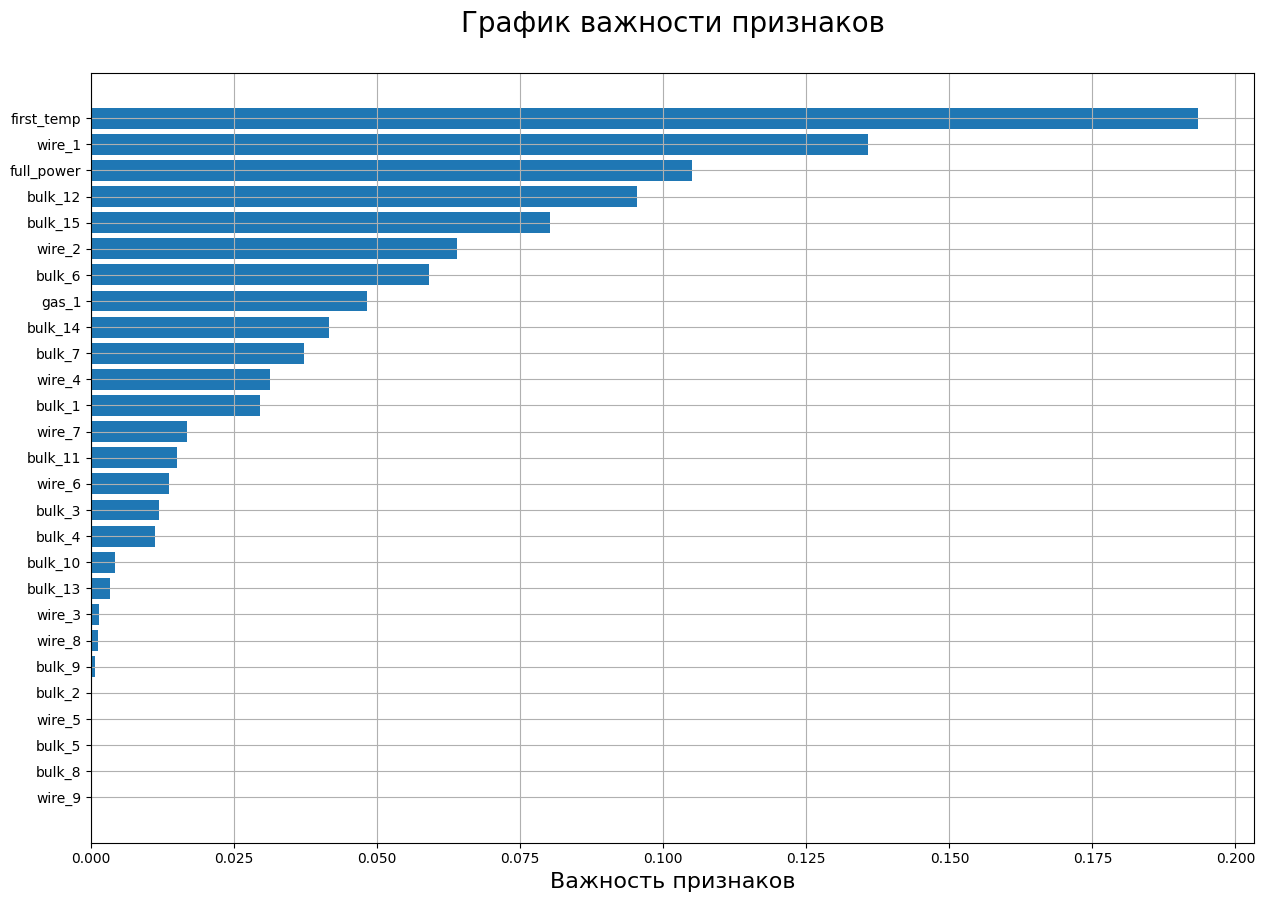

In [79]:
feature_importances()

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты работы с моделями:</b>
        <ol>
        <li>Разные модели обучены.</li>
        <li>Лучшая модель найдена, сравнена с константной и проверена на тестовой выборке, её MAE соответствует заявленным требованиям.</li>
        <li>Проведён анализ важности признаков.</li>
        </ol>
   </p>  
</div>

## 6 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">

### Описание ключевых шагов решения
1. При педобработке данных были переименованы столбцы, обработаны пропуски, устранены аномалии и объединены признаки.
1. Были обучены разные модели и выбрана лучшая.
1. Лучшая модель была сравнена с константной и протестирована на тестовой выборке.

***

### Признаки, которые были использованы для обучения и их предобработка
Были использованы такие признаки:
- `first_temp` и `last_temp` — первая и последняя температура по каждой партии. Были удалены партии с пропусками или одним замером, а также со значениями температуры до 1450.
- `full_power` — суммарная затраченная энергия. Была посчитана по формуле с использованием активной и реактивной мощности. Были удалены партии с отрицательными значениями в столбце с реактивной мощностью.
- `bulk_1` - `bulk_15` и `wire_1` - `wire_9` — данные о подаче сыпучих материалов и о проволочных материалах. Пропуски были заменены на 0. 
- `gas_1` —  данные о продувке сплава газом. Предобработка не потребовалась.

Также, все признаки были масштабированы.

***

### Описание модели
Модель — `GradientBoostingRegressor`.

Гиперпараметры:
- `random_state` = 220523
- `max_depth` = 3
- `min_samples_leaf` = 2
- `min_samples_split` = 10
- `n_estimators` = 83
- `subsample` = 0.7211366976093703

***

### Итоговая метрика
MAE 6.722796	

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">